# Inspection

Here we can investigate the properties of each model that is made.

In [4]:
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as spi

from astropy.io import fits
from IPython.display import clear_output
from kosmatau3d import models
from pprint import pprint

%matplotlib inline

In [2]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/KT3_history/MilkyWay/'

Model

In [3]:
model = 'r400_fhi1.0_fuv1.0'

## Profiles

Here we simply want to examine to examine the various profiles we use to model the Milky Way.

In [3]:
data_dir = models.constants.INPUTPATH + 'MilkyWay/'

### Fix Bacchini et al. (2019) profiles

In [23]:
! ls {data_dir+'bacchini'}

h2_surf_dens.dat  hHE_H2_bin1kpc.txt  hHE_HI_bin1kpc.txt  hi_surf_dens.dat


In [52]:
! cat {data_dir+'bacchini/hHE_H2_bin1kpc.txt'}

# Scaleheights of H2 using the hydrostatic equilibrium in the MW gravitational potential using the model by MACMILLAN+2017. The velocity dispersion is taken from Marasco+2017 for R<8.3 kpc, beyond this it is fixed to 4\pm3 km/s for H2. The errors include only the uncertainty on the velocity dispersion, not on the mass distribution. 
#  1) R kpc 
#  2) h_h2 kpc 
#  3) lowe err kpc 
#  4) upper err kpc
1.000000000000000000e+00 2.135711840412908569e-02 5.219905484723261040e-03 4.782040749451908074e-03
2.000000000000000000e+00 2.655692361074707408e-02 2.059706375039820504e-03 2.082821415404307631e-03
3.000000000000000000e+00 3.057760027378623319e-02 3.261176549964303010e-03 3.348077406642010079e-03
4.000000000000000000e+00 3.397011314748997479e-02 3.599893052848884833e-03 3.679768521206656755e-03
5.000000000000000000e+00 3.730853273843366680e-02 3.927656370372275239e-03 3.726526482227944612e-03
6.000000000000000000e+00 4.116573201437213197e-02 4.148295505395217624e-03 4.144166804931238325e

In [53]:
h_h2 = pd.read_csv(data_dir + 'bacchini/hHE_H2_bin1kpc.txt', delim_whitespace=True, skiprows=5, names=['r', 'h_h2', 'sigma_h_l', 'sigma_h_u'])
h_h2_new = h_h2 * [1, 1000, 1000, 1000]
h_h2_new

,r,h_h2,sigma_h_l,sigma_h_u
0,1.0,21.357118,5.219905,4.782041
1,2.0,26.556924,2.059706,2.082821
2,3.0,30.577600,3.261177,3.348077
3,4.0,33.970113,3.599893,3.679769
4,5.0,37.308533,3.927656,3.726526
5,6.0,41.165732,4.148296,4.144167
6,7.0,46.089083,5.614142,5.653878
7,8.0,52.576154,10.438371,10.438371
8,9.0,61.050405,15.262601,15.262601
9,10.0,71.836887,17.959222,17.959222


In [54]:
h_h2_new.to_csv(data_dir + 'h2_scale-height_bacchini.dat', index=False, sep=' ')

### Scale height

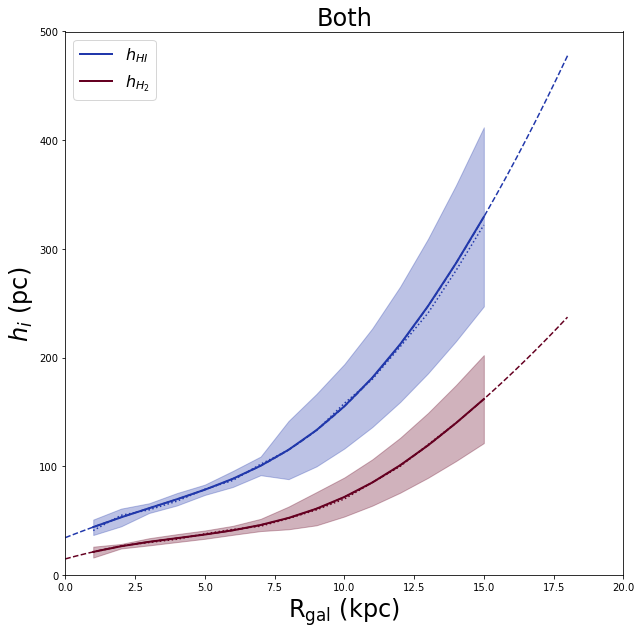

In [58]:
h_h2 = pd.read_csv(data_dir + 'h2_scale-height_bacchini.dat', delim_whitespace=True)
h_hi = pd.read_csv(data_dir + 'hi_scale-height_bacchini.dat', delim_whitespace=True)
h_h2_approx = pd.read_csv(data_dir + 'h2_scale-height_bacchini-approx.dat', delim_whitespace=True)
h_hi_approx = pd.read_csv(data_dir + 'hi_scale-height_bacchini-approx.dat', delim_whitespace=True)

r_new = np.linspace(0, 18)
f_hi = spi.interp1d(h_hi.r, h_hi.h_hi, kind='quadratic', fill_value='extrapolate')
f_h2 = spi.interp1d(h_h2.r, h_h2.h_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))
ax.fill_between(h_hi.r, h_hi.h_hi-h_hi.sigma_h_l, h_hi.h_hi+h_hi.sigma_h_u, color='xkcd:sapphire', alpha=0.3)
ax.plot(h_hi.r, h_hi.h_hi, c='xkcd:sapphire', lw=2, label=r'$h_{HI}$')
ax.plot(r_new, f_hi(r_new), c='xkcd:sapphire', ls='--')
ax.plot(h_hi_approx.r, h_hi_approx.h_hi, ls=':', c='xkcd:sapphire')
ax.fill_between(h_h2.r, h_h2.h_h2-h_h2.sigma_h_l, h_h2.h_h2+h_h2.sigma_h_u, color='xkcd:maroon', alpha=0.3)
ax.plot(h_h2.r, h_h2.h_h2, c='xkcd:maroon', lw=2, label=r'$h_{H_2}$')
ax.plot(r_new, f_h2(r_new), c='xkcd:maroon', ls='--')
ax.plot(h_h2_approx.r, h_h2_approx.h_h2, ls=':', c='xkcd:maroon')
ax.set_title('Both', fontsize=24)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=24)
ax.set_ylabel(r'$h_i$ (pc)', fontsize=24)
ax.set_xlim(0, 20)
ax.set_ylim(0, 500)
ax.legend(fontsize=16) ;

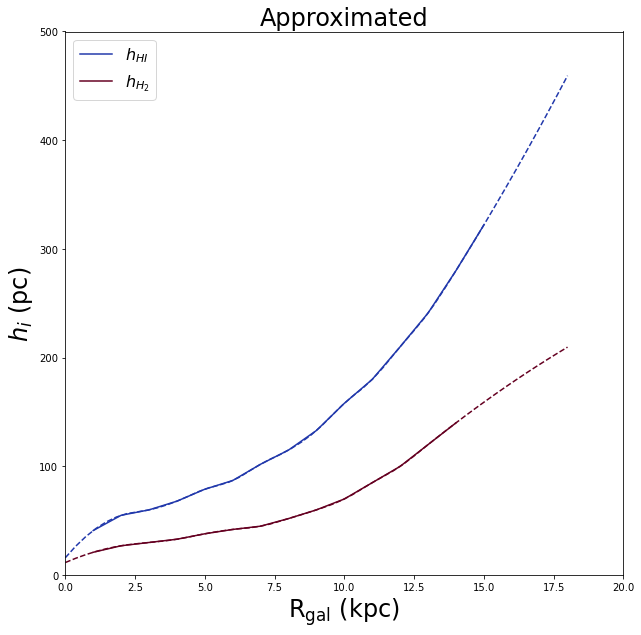

In [ ]:
h_h2 = pd.read_csv(data_dir + 'h2_scale-height_bacchini-approx.dat', delim_whitespace=True)
h_hi = pd.read_csv(data_dir + 'hi_scale-height_bacchini-approx.dat', delim_whitespace=True)

r_new = np.linspace(0, 18)
f_hi = spi.interp1d(h_hi.r, h_hi.h_hi, kind='quadratic', fill_value='extrapolate')
f_h2 = spi.interp1d(h_h2.r, h_h2.h_h2, kind='quadratic', fill_value='extrapolate')

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(h_hi.r, h_hi.h_hi, c='xkcd:sapphire', label=r'$h_{HI}$')
ax.plot(r_new, f_hi(r_new), c='xkcd:sapphire', ls='--')
ax.plot(h_h2.r, h_h2.h_h2, c='xkcd:maroon', label=r'$h_{H_2}$')
ax.plot(r_new, f_h2(r_new), c='xkcd:maroon', ls='--')
ax.set_title('Modelled', fontsize=24)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=24)
ax.set_ylabel(r'$h_i$ (pc)', fontsize=24)
ax.set_xlim(0, 20)
ax.set_ylim(0, 500)
ax.legend(fontsize=16) ;

### $\mathrm{H}_2$ and $\mathrm{HI}$ mass

In [60]:
hi_mass.r2

1.0   0.866874   -0.289738
2.0   0.815698   -0.215769
3.0   4.540022    0.898524
4.0   5.595934    1.326453
5.0   5.336105    1.456260
6.0   7.118091    2.355470
7.0   6.381511    1.944133
8.0   5.305901    1.050700
9.0   6.537676    1.961303
10.0  6.480980    1.944294
11.0  6.620153    1.986046
12.0  6.472098    1.941630
13.0  5.702931    1.710879
14.0  4.794366    1.438310
15.0  4.160178    1.248053
Name: r2, dtype: float64

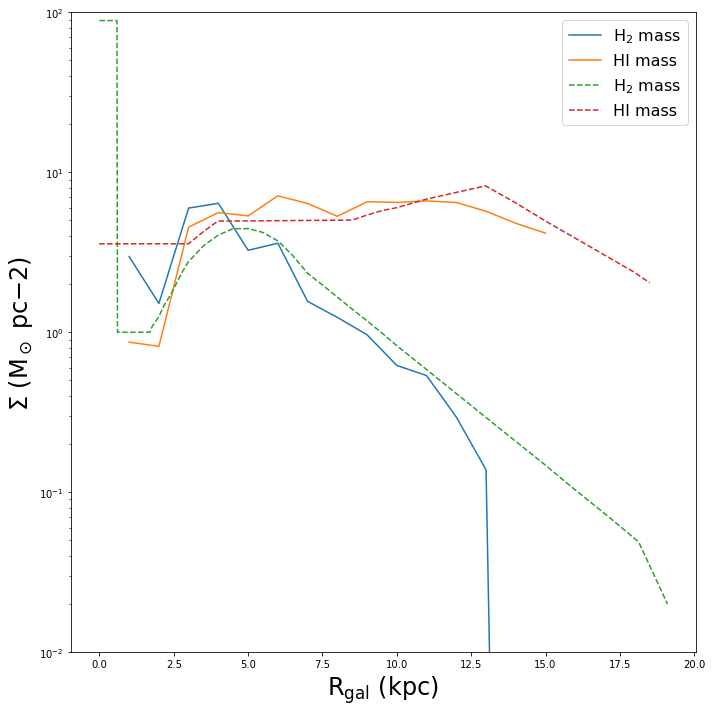

In [67]:
h2_mass = pd.read_csv(data_dir + 'h2_surface-density_bacchini.dat', delim_whitespace=True, usecols=[0, 1], names=['r1', r'H$_2$ mass'], skiprows=1)
hi_mass = pd.read_csv(data_dir + 'hi_surface-density_bacchini.dat', delim_whitespace=True, usecols=[0, 1], names=['r2', 'HI mass'], skiprows=1)
h2_mass_approx = pd.read_csv(data_dir + 'h2_surface-density_wolfire.dat', delim_whitespace=True, names=['r1', r'H$_2$ mass'], skiprows=1)
hi_mass_approx = pd.read_csv(data_dir + 'hi_surface-density_wolfire.dat', delim_whitespace=True, names=['r2', 'HI mass'], skiprows=1)
# mass = pd.concat((h2_mass, hi_mass), axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
h2_mass.plot(x='r1', y=r'H$_2$ mass', logy=True, ax=ax)
hi_mass.plot(x='r2', y='HI mass', logy=True, ax=ax)
h2_mass_approx.plot(x='r1', y=r'H$_2$ mass', ls='--', logy=True, ax=ax)
hi_mass_approx.plot(x='r2', y='HI mass', ls='--', logy=True, ax=ax)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=24)
ax.set_ylabel(r'$\Sigma$ (M$_\odot$ pc${-2}$)', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(1e-2, 1e2)
fig.tight_layout()
plt.savefig('plots/surface-density_comp.png') ;

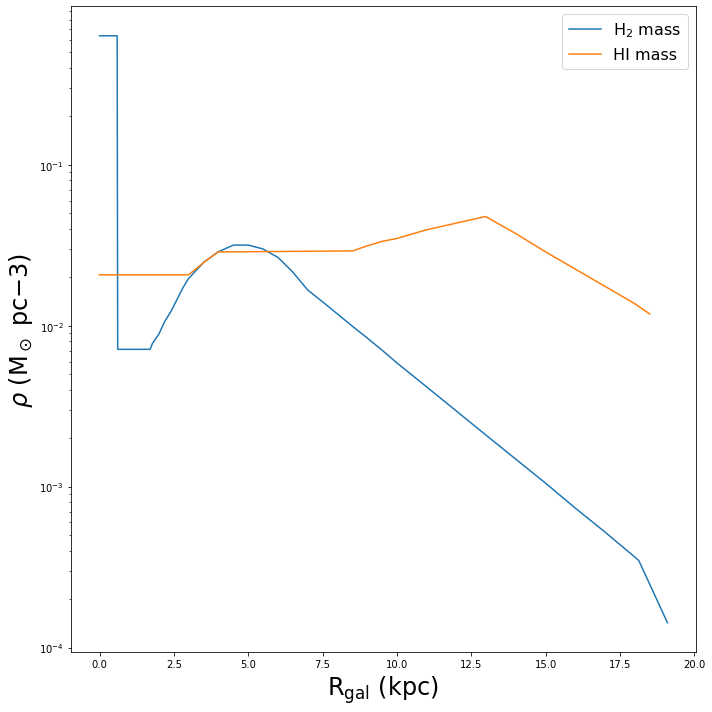

In [17]:
h2_mass = pd.read_csv(data_dir + 'h2_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r1', r'H$_2$ mass'], skiprows=1)
hi_mass = pd.read_csv(data_dir + 'hi_mass-density_wolfire-approx.dat', delim_whitespace=True, names=['r2', 'HI mass'], skiprows=1)
# mass = pd.concat((h2_mass, hi_mass), axis=1)

fig, ax = plt.subplots(figsize=(10, 10))
h2_mass.plot(x='r1', y=r'H$_2$ mass', logy=True, ax=ax)
hi_mass.plot(x='r2', y='HI mass', logy=True, ax=ax)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=24)
ax.set_ylabel(r'$\rho$ (M$_\odot$ pc${-3}$)', fontsize=24)
ax.legend(fontsize=16)
fig.tight_layout()
plt.savefig('plots/volume-density_wolfire.png') ;

In [50]:
list(_ if _<3 else -10 if _>6 else np.nan for _ in range(10))

[0, 1, 2, nan, nan, nan, nan, -10, -10, -10]

In [20]:
r = np.hstack((hi_mass['r2'], hi_mass['r2'], hi_mass['r2']))
z = np.hstack((np.zeros_like(hi_mass['HI mass'], dtype=float), np.full_like(hi_mass['HI mass'], 50, dtype=float), np.full_like(hi_mass['HI mass'], 100, dtype=float)))
m = np.hstack((hi_mass['HI mass'], .5*hi_mass['HI mass'], .3*hi_mass['HI mass']))
data = pd.DataFrame(data={'R(pc)':r*1000, 'h(pc)':z, 'M(M_sol)':m})
data

,R(pc),h(pc),M(M_sol)
0,-10.0,0.0,0.020747
1,97.2,0.0,0.020747
2,1191.2,0.0,0.020747
3,2990.3,0.0,0.020747
4,3233.4,0.0,0.022521
...,...,...,...
58,15000.0,100.0,0.008643
59,15996.8,100.0,0.006756
60,16993.5,100.0,0.005282
61,17990.3,100.0,0.004129


### Number density

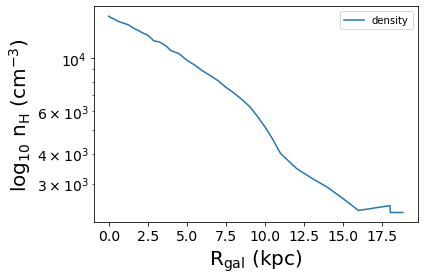

In [16]:
%matplotlib inline
density = pd.read_csv(data_dir + 'densities_clouds.dat', delim_whitespace=True, names=['r', 'density'], skiprows=1)
fig, ax = plt.subplots(1, 1)
density.plot(x='r', y='density', ax=ax, logy=True, fontsize=14)
ax.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=20)
ax.set_ylabel(r'log$_{10}$ n$_\mathrm{H}$ (cm$^{-3}$)', fontsize=20)
fig.tight_layout()
plt.savefig('plots/density_dist.png');

### far-UV

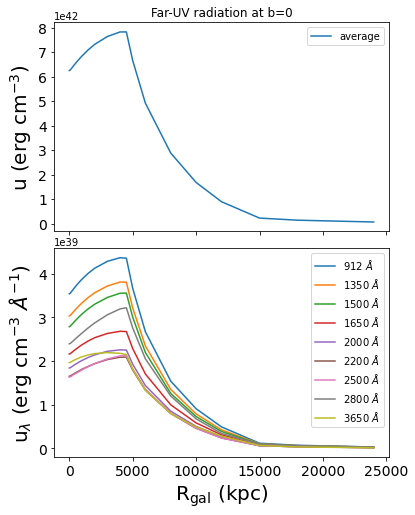

In [23]:
%matplotlib inline
fuv = pd.read_csv(data_dir + 'galactic_FUV_complete.dat', delim_whitespace=True, names=['r', 'z', 'average', r'912 $\AA$', r'1350 $\AA$', r'1500 $\AA$', r'1650 $\AA$', r'2000 $\AA$', r'2200 $\AA$', r'2500 $\AA$', r'2800 $\AA$', r'3650 $\AA$'], skiprows=1)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace':0.08}, figsize=(6, 8))
fuv.groupby('r').max().reset_index().plot(x='r', y='average', ax=ax1, title='Far-UV radiation at b=0', fontsize=14)
fuv.groupby('r').max().reset_index().plot(x='r', y=[r'912 $\AA$', r'1350 $\AA$', r'1500 $\AA$', r'1650 $\AA$', r'2000 $\AA$', r'2200 $\AA$', r'2500 $\AA$', r'2800 $\AA$', r'3650 $\AA$'], ax=ax2, fontsize=14)
ax2.set_xlabel(r'R$_\mathrm{gal}$ (kpc)', fontsize=20)
ax1.set_ylabel(r'u (erg cm$^{-3}$)', fontsize=20)
ax2.set_ylabel(r'u$_\lambda$ (erg cm$^{-3}$ $\AA^{-1}$)', fontsize=20)
# fig.tight_layout()
plt.savefig('plots/fuv_dist.png');

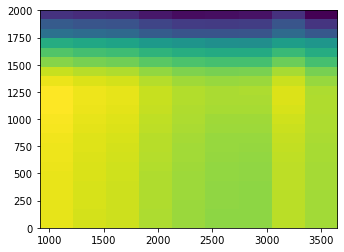

In [121]:
plt.imshow(np.log10(fuv.groupby('r').max()[[912, 1350, 1500, 1650, 2000, 2200, 2500, 2800, 3650]]).to_numpy()[::-1, :], extent=(912, 3650, 0, 2000))

## Distributions

### Mass

In [4]:
positions = fits.open(base_dir + model + '/voxel_position.fits')
mass = fits.open(base_dir + model + '/voxel_ensemble_mass.fits')

In [7]:
mass[0].data.sum(1).shape, x.shape

((6349,), (6349,))

In [15]:
z.max()

1.0

In [20]:
x, y, z = positions[0].data.T
z = np.random.rand(z.size)
values = mass[0].data.sum(1)*400
fig = go.Figure(data=go.Volume(x=x, 
                               y=y, 
                               z=z, 
                               value=values, 
                               isomin=0, 
                               isomax=values.max(), 
                               opacity=0.5, 
                               surface_count=50))

In [ ]:
fig.show()

### Intensity

In [31]:
intensity = fits.open(base_dir + model + '/synthetic_intensity.fits')
# pprint(intensity[1].header)

In [26]:
lon = np.linspace(intensity[1].header['CRVAL2'] - (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  intensity[1].header['CRVAL2'] + (intensity[1].header['CRPIX2']-0.5)*intensity[1].header['CDELT2'],
                  num=intensity[1].header['NAXIS2'])
lat = np.linspace(intensity[1].header['CRVAL3'] - (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  intensity[1].header['CRVAL3'] + (intensity[1].header['CRPIX3']-0.5)*intensity[1].header['CDELT3'],
                  num=intensity[1].header['NAXIS3'])
vel = np.linspace(intensity[1].header['CRVAL4'] - (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  intensity[1].header['CRVAL4'] + (intensity[1].header['CRPIX4']-0)*intensity[1].header['CDELT4'],
                  num=intensity[1].header['NAXIS4'])

In [27]:
x, y, z = np.meshgrid(vel, lat, lon)
values = intensity[1].data[:, :, :, 0]

fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))

In [28]:
fig.show()

## Observational data

In [31]:
base_dir = '/mnt/hpc_backup/yanitski/projects/pdr/observational_data/MilkyWay/COGAL/'

# obs = fits.open(base_dir + 'COGAL_deep_interp.fits')
obs = fits.open(base_dir + 'regridded/temp/co1_test_regridded.fits')
x = np.arange(obs[0].header['NAXIS1'])
y = np.arange(obs[0].header['NAXIS2'])
z = np.arange(obs[0].header['NAXIS3'])
X, Y, Z = np.meshgrid(x, y, z)
fig = go.Figure(data=go.Volume(x=X.flatten(), y=Y.flatten(), z=Z.flatten(), value=obs[0].data.flatten(), surface_count=20))

In [32]:
fig.show()

In [8]:
np.where(np.isnan(obs[0].data))[0].size

42008126

## Examples

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np


def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((17, 17, 17)) / 16.0
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)

# define a sphere about [0.5, 0.5, 0.5]
sphere = (rc - 0.5)**2 + (gc - 0.5)**2 + (bc - 0.5)**2 < 0.5**2

# combine the color components
colors = np.zeros(sphere.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc

# and plot everything
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
ax.voxels(r, g, b, sphere,
          facecolors=colors,
          # edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          alpha=0.7,
          linewidth=0.5)
ax.set(xlabel='r', ylabel='g', zlabel='b') ;

In [17]:
np.where(np.isnan(values))[0].size

0

In [20]:
values.shape

(40, 40, 40)

In [ ]:
import plotly.graph_objects as go
import numpy as np
X, Y, Z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(X*Y*Z) / (X*Y*Z)

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=-0.1,
    isomax=0.8,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np
x, y, z = np.mgrid[-8:8:40j, -8:8:40j, -8:8:40j]
values = np.sin(x*y*z) / (x*y*z)
fig = go.Figure(data=go.Volume(
    x=x.flatten(),
    y=y.flatten(),
    z=z.flatten(),
    value=values.flatten(),
    isomin=0.1,
    isomax=0.8,
    opacity=0.2, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    ))
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(x=["a", "b", "c"], y=[1, 3, 2])
fig.show()